In [106]:
import os
import tiktoken
import openai
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from openai.embeddings_utils import cosine_similarity
from tenacity import retry, wait_random_exponential, stop_after_attempt

Exception ignored in: <function NebulaGraphStore.__del__ at 0x0000023A5506EEF0>
Traceback (most recent call last):
  File "c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\llama_index\graph_stores\nebulagraph.py", line 154, in __del__
    self._session_pool.close()
AttributeError: 'NebulaGraphStore' object has no attribute '_session_pool'
Exception ignored in: <function NebulaGraphStore.__del__ at 0x0000023A5506EEF0>
Traceback (most recent call last):
  File "c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\llama_index\graph_stores\nebulagraph.py", line 154, in __del__
    self._session_pool.close()
AttributeError: 'NebulaGraphStore' object has no attribute '_session_pool'


In [107]:
from dotenv import load_dotenv
load_dotenv()
import openai

In [108]:
df = pd.read_csv('./data/data_science_jobs_indeed_usa.csv')

In [109]:
encoding = tiktoken.get_encoding('cl100k_base')

In [110]:
df = df.assign(token_count=df['Description'].apply(lambda x: len(encoding.encode(x))))

In [111]:
print(df.shape)
df.head()

(1200, 11)


,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25
2,2,IT Business Intelligence Developer (FT) Remote...,Ballad Health,"Remote in Blountville, TN",3.0,PostedPosted 30+ days ago,NaN,Job Details Apply Save Print this job Email a…,https://www.indeed.com/rc/clk?jk=58612836c63b8...,Job Details\nApply\nSave\nPrint this job\nEmai...,10
3,3,Data Engineer,Longevity Holdings Inc.,"Remote in Minneapolis-Saint Paul, MN",NaN,PostedPosted 3 days ago,"$90,000 - $110,000 a year",Incorporate core data management competencies ...,https://www.indeed.com/company/TwentyFirst/job...,Position: Data Engineer\nLocation: MN\nAs a Da...,29
4,4,Network Administrator/dba developer,WKI Kenworth,"Wichita, KS 67219",NaN,EmployerActive 2 days ago,"$50,000 - $70,000 a year",The Network Administrator provides 2nd level e...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Full Job Description\nThe Network Administrato...,28


In [112]:
# Azure: 
# @retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
# def get_embedding(text) -> list[float]:
#     text = text.replace("\n", " ")
#     return openai.Embedding.create(input=text, engine=OpenAiEmbedding)["data"][0]["embedding"]

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [113]:
df = df.assign(embedding=df['Description'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002')))
df.head()

,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count,embedding
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26,"[-0.0194996390491724, -0.0041993726044893265, ..."
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25,"[-0.012073525227606297, -0.026480479165911674,..."
2,2,IT Business Intelligence Developer (FT) Remote...,Ballad Health,"Remote in Blountville, TN",3.0,PostedPosted 30+ days ago,NaN,Job Details Apply Save Print this job Email a…,https://www.indeed.com/rc/clk?jk=58612836c63b8...,Job Details\nApply\nSave\nPrint this job\nEmai...,10,"[-0.021908748894929886, -0.002960818586871028,..."
3,3,Data Engineer,Longevity Holdings Inc.,"Remote in Minneapolis-Saint Paul, MN",NaN,PostedPosted 3 days ago,"$90,000 - $110,000 a year",Incorporate core data management competencies ...,https://www.indeed.com/company/TwentyFirst/job...,Position: Data Engineer\nLocation: MN\nAs a Da...,29,"[-0.017482835799455643, -0.01076465379446745, ..."
4,4,Network Administrator/dba developer,WKI Kenworth,"Wichita, KS 67219",NaN,EmployerActive 2 days ago,"$50,000 - $70,000 a year",The Network Administrator provides 2nd level e...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Full Job Description\nThe Network Administrato...,28,"[0.0011034636991098523, -0.000915585900656879,..."


In [164]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

class KMeansWithProbs:
    def __init__(self, n_clusters, covariance_type='full', max_iter=100, random_state=0):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state)
        self.gmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type=covariance_type,
                                            max_iter=max_iter, random_state=random_state)
    
    def fit(self, X):
        self.kmeans.fit(X)
        self.gmm.fit(X)
        return self
    
    def predict(self, X):
        return self.kmeans.predict(X)
    
    def predict_proba(self, X):
        return self.gmm.predict_proba(X)

    def silhouette_score(self, X):
        labels = self.predict(X)
        return silhouette_score(X, labels)
    
    def bic(self, X):
        log_likelihood = self.bgmm.score_samples(X).sum()
        num_parameters = (self.n_clusters - 1) + self.n_clusters * X.shape[1]
        if self.bgmm.covariance_type == 'full':
            num_parameters += self.n_clusters
        return log_likelihood - 0.5 * num_parameters * np.log(X.shape[0])
    
    def tune_clusters(self, X, min_clusters=2, max_clusters=10):
        silhouettes = []
        bics = []
        avg_top_probs = []
        cluster_range = range(min_clusters, max_clusters + 1)
        
        for n_clusters in cluster_range:
            self.n_clusters = n_clusters
            self.kmeans = KMeans(n_clusters=n_clusters, random_state=0)
            self.bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
            self.fit(X)
            
            silhouettes.append(self.silhouette_score(X))
            bics.append(-self.bic(X))  # Flipping the sign of BIC
            avg_top_probs.append(self.predict_proba(X, top_n=1).mean())

        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.plot(cluster_range, silhouettes, marker='o')
        plt.title('Silhouette scores')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        
        plt.subplot(132)
        plt.plot(cluster_range, bics, marker='o')  # Sign-flipped BIC
        plt.title('Negative BIC')
        plt.xlabel('Number of clusters')
        plt.ylabel('Negative BIC')
        
        plt.subplot(133)
        plt.plot(cluster_range, avg_top_probs, marker='o')
        plt.title('Average top cluster probability')
        plt.xlabel('Number of clusters')
        plt.ylabel('Avg top probability')
        
        plt.tight_layout()
        plt.show()

In [165]:
# Importing required libraries
import numpy as np
from sklearn.datasets import make_blobs

# Generate synthetic data
X, y = make_blobs(n_samples=300, centers=3, random_state=0)

# Create an instance of the KMeansWithProbs class
n_clusters = 3
kmeans_with_probs = KMeansWithProbs(n_clusters)

# Fit the model to the data
# Fit the model and predict the labels
kmeans_with_probs.fit(X)

# Calculate the silhouette score
s_score = kmeans_with_probs.silhouette_score(X)
print(f'Silhouette Score: {s_score}')

# Calculate the Bayesian Information Criterion
# bic_value = kmeans_with_probs.bic(X)
# print(f'BIC: {bic_value}')

Silhouette Score: 0.4841542003442777


c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [175]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import kde

class KMeansWithProbs:
    
    def __init__(self, n_clusters, covariance_type='full', max_iter=100, random_state=0):
        self.n_clusters = n_clusters
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.random_state = random_state
        self.kmeans = None
        self.bgmm = None
    
    def fit(self, X):
        self.kmeans = KMeans(n_clusters=self.n_clusters, max_iter=self.max_iter, random_state=self.random_state)
        self.kmeans.fit(X)
        self.bgmm = BayesianGaussianMixture(n_components=self.n_clusters, covariance_type=self.covariance_type,
                                            max_iter=self.max_iter, random_state=self.random_state)
        self.bgmm.fit(X)
        return self
    
    def predict(self, X):
        return self.kmeans.predict(X)
    
    def predict_proba(self, X, top_n=None):
        probs = self.bgmm.predict_proba(X)
        if top_n is not None:
            partition_idx = np.argpartition(-probs, top_n, axis=1)[:, :top_n]
            top_probs = -np.sort(-probs[np.arange(probs.shape[0])[:, None], partition_idx])
            sorted_indices = np.argsort(-probs[np.arange(probs.shape[0])[:, None], partition_idx])
            return top_probs, sorted_indices
        return probs, np.argsort(-probs, axis=1)

    def silhouette_score(self, X):
        labels = self.predict(X)
        return silhouette_score(X, labels)
    
    def bic(self, X):
        log_likelihood = self.bgmm.score_samples(X).sum()
        num_parameters = (self.n_clusters - 1) + self.n_clusters * X.shape[1]
        if self.bgmm.covariance_type == 'full':
            num_parameters += self.n_clusters
        return log_likelihood - 0.5 * num_parameters * np.log(X.shape[0])

    def tune_clusters(self, X, min_clusters=2, max_clusters=10):
        silhouettes = []
        bics = []
        avg_top_probs = []
        cluster_range = range(min_clusters, max_clusters + 1)
        
        for n_clusters in cluster_range:
            self.n_clusters = n_clusters
            self.kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto",)
            self.bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
            self.fit(X)
            
            silhouettes.append(self.silhouette_score(X))
            bics.append(self.bic(X))  # No need to flip the sign
            avg_top_probs.append(self.predict_proba(X, top_n=1)[0].mean())

        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.plot(cluster_range, silhouettes, marker='o')
        plt.title('Silhouette scores')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        
        plt.subplot(132)
        plt.plot(cluster_range, bics, marker='o')  # Sign-flipped BIC
        plt.title('Negative BIC')
        plt.xlabel('Number of clusters')
        plt.ylabel('Negative BIC')
        
        plt.subplot(133)
        plt.plot(cluster_range, avg_top_probs, marker='o')
        plt.title('Average top cluster probability')
        plt.xlabel('Number of clusters')
        plt.ylabel('Avg top probability')
        
        plt.tight_layout()
        plt.show()


c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\skle

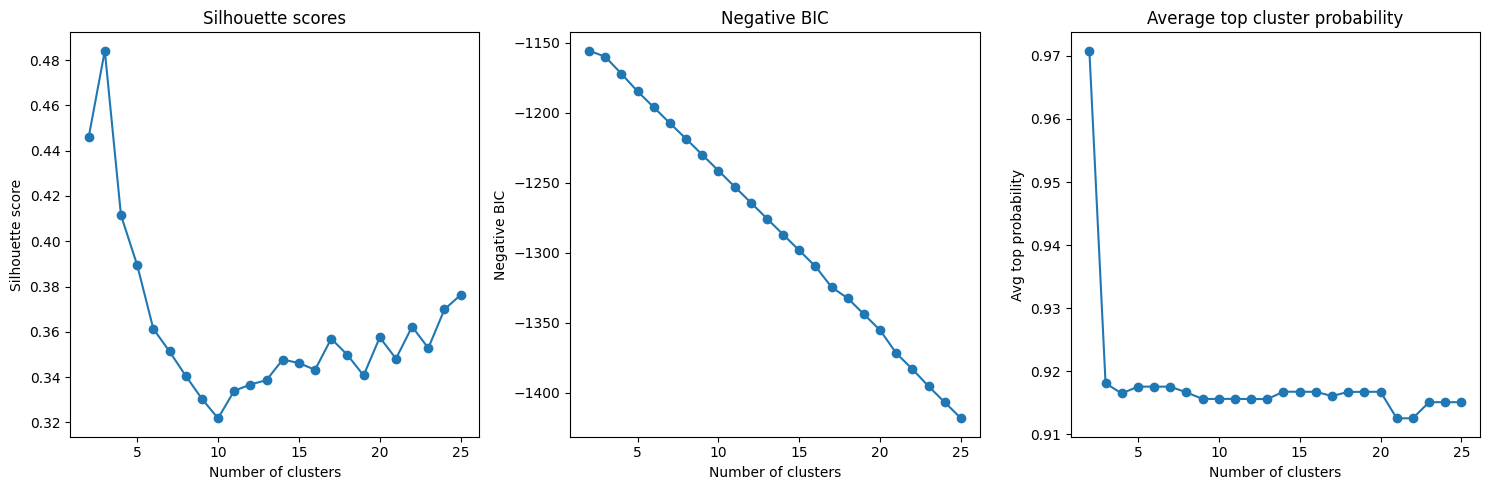

In [176]:
kmeans_with_probs = KMeansWithProbs(n_clusters=2)  # Initial number of clusters doesn't matter here
kmeans_with_probs.tune_clusters(X, min_clusters=2, max_clusters=25)

In [190]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import kde
from scipy.stats import zscore

class KMeansWithProbs:
    
    def __init__(self, n_clusters, covariance_type='full', max_iter=100, random_state=0):
        self.n_clusters = n_clusters
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.random_state = random_state
        self.kmeans = None
        self.bgmm = None
    
    def fit(self, X):
        self.kmeans = KMeans(n_clusters=self.n_clusters, max_iter=self.max_iter, random_state=self.random_state, n_init="auto",)
        self.kmeans.fit(X)
        self.bgmm = BayesianGaussianMixture(n_components=self.n_clusters, covariance_type=self.covariance_type,
                                            max_iter=self.max_iter, random_state=self.random_state)
        self.bgmm.fit(X)
        return self
    
    def predict(self, X):
        return self.kmeans.predict(X)
    
    def predict_proba(self, X, top_n=None):
        probs = self.bgmm.predict_proba(X)
        if top_n is not None:
            partition_idx = np.argpartition(-probs, top_n, axis=1)[:, :top_n]
            top_probs = -np.sort(-probs[np.arange(probs.shape[0])[:, None], partition_idx])
            sorted_indices = np.argsort(-probs[np.arange(probs.shape[0])[:, None], partition_idx])
            return top_probs, sorted_indices
        return probs, np.argsort(-probs, axis=1)

    def silhouette_score(self, X):
        labels = self.predict(X)
        return silhouette_score(X, labels)
    
    def bic(self, X):
        log_likelihood = self.bgmm.score_samples(X).sum()
        num_parameters = (self.n_clusters - 1) + self.n_clusters * X.shape[1]
        if self.bgmm.covariance_type == 'full':
            num_parameters += self.n_clusters * X.shape[1] * (X.shape[1] + 1) / 2  # number of elements in a covariance matrix
        return log_likelihood - 0.5 * num_parameters * np.log(X.shape[0])

    def tune_clusters(self, X, min_clusters=2, max_clusters=10):
        silhouettes = []
        bics = []
        avg_probs = []
        cluster_range = range(min_clusters, max_clusters + 1)
        
        for n_clusters in cluster_range:
            self.n_clusters = n_clusters
            self.kmeans = KMeans(n_clusters=n_clusters, random_state=0)
            self.bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
            self.fit(X)
            
            silhouettes.append(self.silhouette_score(X))
            bics.append(self.bic(X))
            avg_probs.append(self.predict_proba(X)[0].mean())  # Compute average of all probabilities
        
        # Compute z-scores of average probabilities
        z_scores = zscore(avg_probs)
        
        # 2D Density plot
        nbins = 300
        x, y, z = silhouettes, bics, z_scores
        k = kde.gaussian_kde([x, y])
        xi, yi = np.mgrid[min(x):max(x):nbins*1j, min(y):max(y):nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        plt.figure(figsize=(8,8))
        plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='viridis')
        plt.colorbar(label='Z-score of average probability')
        scatter = plt.scatter(x, y, c=z, s=100, edgecolor='white', cmap='viridis')
        plt.xlabel('Silhouette score')
        plt.ylabel('BIC')
        plt.title('Contour plot of clustering metrics')

        # Label points with the corresponding number of clusters
        for i, txt in enumerate(cluster_range):
            plt.annotate(txt, (x[i], y[i]))

        plt.show()

C:\Users\pdoub\AppData\Local\Temp\ipykernel_13232\1890529557.py:72: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


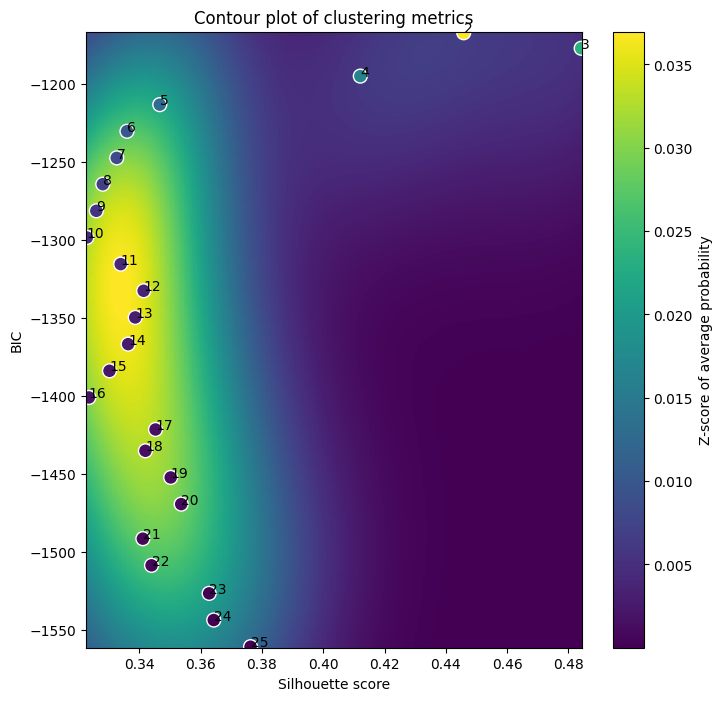

In [191]:
kmeans_with_probs = KMeansWithProbs(n_clusters=2)  # Initial number of clusters doesn't matter here
kmeans_with_probs.tune_clusters(X, min_clusters=2, max_clusters=25)


In [185]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import kde

class KMeansWithProbs:
    
    def __init__(self, n_clusters, covariance_type='full', max_iter=100, random_state=0):
        self.n_clusters = n_clusters
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.random_state = random_state
        self.kmeans = None
        self.bgmm = None
    
    def fit(self, X):
        self.kmeans = KMeans(n_clusters=self.n_clusters, max_iter=self.max_iter, random_state=self.random_state, n_init="auto",)
        self.kmeans.fit(X)
        self.bgmm = BayesianGaussianMixture(n_components=self.n_clusters, covariance_type=self.covariance_type,
                                            max_iter=self.max_iter, random_state=self.random_state)
        self.bgmm.fit(X)
        return self
    
    def predict(self, X):
        return self.kmeans.predict(X)
    
    def predict_proba(self, X, top_n=None):
        probs = self.bgmm.predict_proba(X)
        if top_n is not None:
            partition_idx = np.argpartition(-probs, top_n, axis=1)[:, :top_n]
            top_probs = -np.sort(-probs[np.arange(probs.shape[0])[:, None], partition_idx])
            sorted_indices = np.argsort(-probs[np.arange(probs.shape[0])[:, None], partition_idx])
            return top_probs, sorted_indices
        return probs, np.argsort(-probs, axis=1)

    def silhouette_score(self, X):
        labels = self.predict(X)
        return silhouette_score(X, labels)
    
    def bic(self, X):
        log_likelihood = self.bgmm.score_samples(X).sum()
        num_parameters = (self.n_clusters - 1) + self.n_clusters * X.shape[1]
        if self.bgmm.covariance_type == 'full':
            num_parameters += self.n_clusters * X.shape[1] * (X.shape[1] + 1) / 2  # number of elements in a covariance matrix
        return log_likelihood - 0.5 * num_parameters * np.log(X.shape[0])

    def tune_clusters(self, X, min_clusters=2, max_clusters=10, prob_threshold=0.8):
        silhouettes = []
        bics = []
        high_prob_props = []
        cluster_range = range(min_clusters, max_clusters + 1)
        
        for n_clusters in cluster_range:
            self.n_clusters = n_clusters
            self.kmeans = KMeans(n_clusters=n_clusters, random_state=0)
            self.bgmm = BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
            self.fit(X)
            
            silhouettes.append(self.silhouette_score(X))
            bics.append(self.bic(X))

            probs = self.predict_proba(X)[0]
            high_prob_props.append(np.mean(probs > prob_threshold))  # Proportion of points with high probability

        # 2D Density plot
        nbins = 300
        x, y, z = silhouettes, bics, high_prob_props
        k = kde.gaussian_kde([x, y])
        xi, yi = np.mgrid[min(x):max(x):nbins*1j, min(y):max(y):nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        plt.figure(figsize=(8,8))
        plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='viridis')
        plt.colorbar(label='Proportion of high-probability assignments')
        scatter = plt.scatter(x, y, c=z, s=100, edgecolor='white', cmap='viridis')
        plt.xlabel('Silhouette score')
        plt.ylabel('BIC')
        plt.title('Contour plot of clustering metrics')

        # Label points with the corresponding number of clusters
        for i, txt in enumerate(cluster_range):
            plt.annotate(txt, (x[i], y[i]))

        plt.show()

C:\Users\pdoub\AppData\Local\Temp\ipykernel_13232\980222963.py:70: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


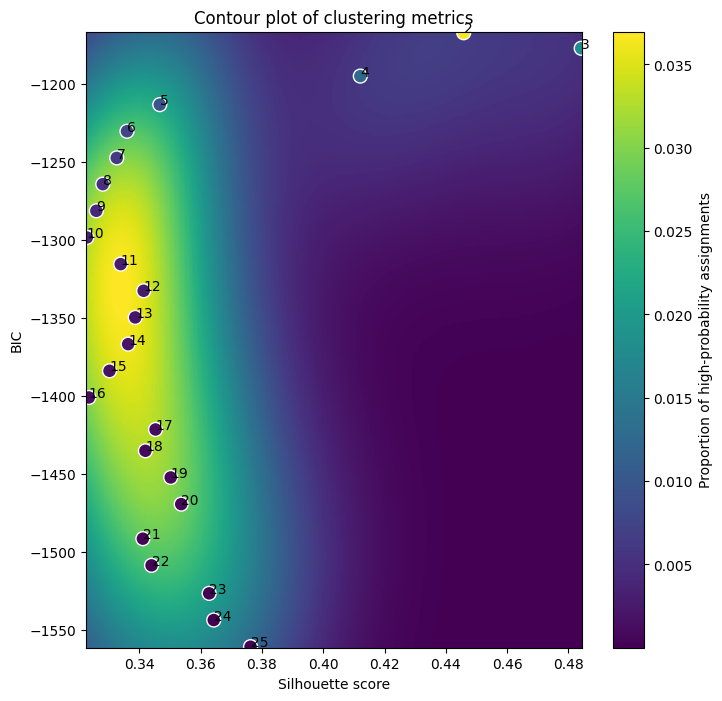

In [186]:
kmeans_with_probs = KMeansWithProbs(n_clusters=2)  # Initial number of clusters doesn't matter here
kmeans_with_probs.tune_clusters(X, min_clusters=2, max_clusters=25, prob_threshold=0.95)

In [ ]:
def identify_original_documents(documents, chunks):
    """
    This function identifies the original document(s) each chunk came from.
    Args:
    documents: A list of original documents.
    chunks: A list of text chunks.
    Returns:
    chunks: The provided chunks with appended page info.
    """
    # Combine all documents into a single string and track their ranges.
    long_string = ""
    pages_dict = {}
    for i, doc in enumerate(documents):
        start = len(long_string)
        long_string += doc.text
        end = len(long_string)
        pages_dict[i] = (start, end)

    # Identify the original document(s) for each chunk.
    for i, chunk in enumerate(chunks):
        chunk_start = long_string.find(chunk.text)
        chunk_end = chunk_start + len(chunk.text)
        pages = []
        for doc_number, (doc_start, doc_end) in pages_dict.items():
            if (chunk_start >= doc_start and chunk_start < doc_end) or (chunk_end > doc_start and chunk_end <= doc_end):
                pages.append(doc_number + 1)
        # Update existing metadata dictionary
        chunk.metadata.update({'pages': ', '.join(map(str, pages))})

    return chunks


In [12]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(df['embedding'].to_list())
df = df.assign(cluster=kmeans.labels_)
df.head()

c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count,embedding,cluster
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26,"[-0.0194996390491724, -0.0041993726044893265, ...",2
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25,"[-0.012073525227606297, -0.026480479165911674,...",4
2,2,IT Business Intelligence Developer (FT) Remote...,Ballad Health,"Remote in Blountville, TN",3.0,PostedPosted 30+ days ago,NaN,Job Details Apply Save Print this job Email a…,https://www.indeed.com/rc/clk?jk=58612836c63b8...,Job Details\nApply\nSave\nPrint this job\nEmai...,10,"[-0.021908748894929886, -0.002960818586871028,...",4
3,3,Data Engineer,Longevity Holdings Inc.,"Remote in Minneapolis-Saint Paul, MN",NaN,PostedPosted 3 days ago,"$90,000 - $110,000 a year",Incorporate core data management competencies ...,https://www.indeed.com/company/TwentyFirst/job...,Position: Data Engineer\nLocation: MN\nAs a Da...,29,"[-0.017482835799455643, -0.01076465379446745, ...",7
4,4,Network Administrator/dba developer,WKI Kenworth,"Wichita, KS 67219",NaN,EmployerActive 2 days ago,"$50,000 - $70,000 a year",The Network Administrator provides 2nd level e...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Full Job Description\nThe Network Administrato...,28,"[0.0011398864444345236, -0.0008925285073928535...",0


In [20]:
df.Title.nunique()

566

(1200, 1536)


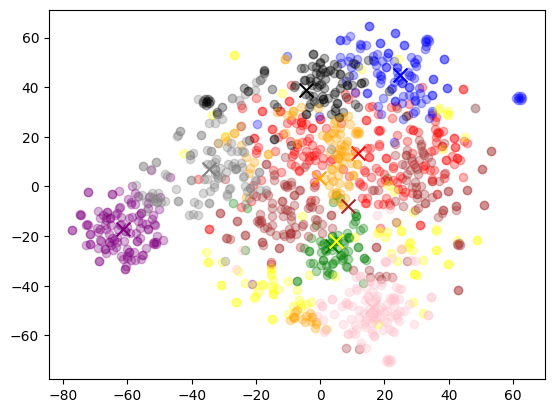

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)

matrix = np.vstack(df.embedding.values)
print(matrix.shape)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow", 'black', 'orange', 'brown', 'pink', 'grey']):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

In [17]:
# take 10 samples from each cluster and write a prompt that asks what these have in common
# ideally you would use more than 10, but this is just a demo
for i in range(n_clusters):
    reviews = df[df['cluster'] == i]['Description'].sample(10)
    reviews = "\n".join(reviews.values.tolist())
    
    prompt = f"Here are 10 job descriptions:\n{reviews}Write a 3 to 5 word topic reflecting what these have in common."
    #print(prompt)
    response = openai.Completion.create(model="text-davinci-003", prompt=prompt, temperature=0.15, max_tokens=100, top_p=1, frequency_penalty=0, presence_penalty=0, stop=None)['choices'][0]['text'].strip()
    print(f"Cluster {i} topics: {response}")
    jobs = df[df['cluster'] == i]['Title'].sample(25)
    print(f"Jobs from cluster {i}: {', '.join(jobs.values.tolist())}")
    print("================")

Cluster 0 topics: Database Administration.
Jobs from cluster 0: Database Administrator, Database Administrator (Direct Hire/Remote), Database Administrator - Oracle (100% Remote), Oracle Database Administrator, Database Administrator, Database Administrator, Database Administrator II, DATABASE ADMINISTRATOR- SQL SERVER- CLT/REMOTE, SQL Server Database Administrator II - (Remote from anywhere in CO), Database Administrator, DATABASE ADMINISTRATOR, Database Administrator, Database Administrator 2, Database Administrator - Open to 100% Remote, Junior SQL Server Database Administrator, Database Administrator, IT Database Administrator / Senior Administrator, Database Administrator, Database Specialist, SQL Server/Db2 Database Administrator, Jr. SQL Database Administrator, Database Administrator, Database Administrator 5, SQL Database Administrator, Database Administrator
Cluster 1 topics: Business Intelligence Tools.
Jobs from cluster 1: Junior Developer – Business Intelligence (ETL), Busi

In [19]:
ds_job = "Data Scientist"

# get embedding for movie
e = df[df['Title'] == ds_job]['embedding'].values[0]

# get cosine similarity between movie and all other movies and sort ascending
similarities = df['embedding'].apply(lambda x: cosine_similarity(x, e))

# get most similar movies
movies = df.assign(similarity=similarities).sort_values(by='similarity', ascending=False)[['Title', 'similarity', 'Description']]
movies[1:10]

,Title,similarity,Description
763,"Manager, Data Science & Analytics, Central Ana...",0.915978,"You will collaborate with data engineers, data..."
1130,"Manager, Data Science",0.908001,You will work to develop data science solution...
77,Data Scientist,0.902445,You will be a member of a multidisciplinary te...
1159,Data Scientist,0.902279,You will be a member of a multidisciplinary te...
236,"Senior Software Development Engineer, Big Data",0.900152,"Collaborate with engineers, product managers, ..."
354,Data Scientist,0.897500,"Work closely with analysts, traders, developer..."
149,Data Scientist,0.895616,You'll work closely with other data scientists...
326,Data Science Lead,0.890732,"As a Lead, you will be leading and growing a t..."
398,Data Engineer,0.886443,Collaborate with data analysts/scientists and ...


In [56]:
from llama_index import SimpleDirectoryReader, ServiceContext, KnowledgeGraphIndex, StorageContext
from llama_index.graph_stores import SimpleGraphStore
from llama_index.llms import OpenAI
from IPython.display import Markdown, display

In [57]:
from pathlib import Path

documents = SimpleDirectoryReader(input_files=['./data/HO3_sample.pdf']).load_data()

In [4]:
llm=OpenAI(temperature=0, model_name="text-davinci-002")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size_limit=512)

graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

In [6]:
index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=2,
    storage_context=storage_context,
    service_context=service_context,
    include_embeddings=True
)

index.set_index_id("ho3_kg_index")
index.storage_context.persist(persist_dir="./ho3_kg_index")

In [23]:
index.storage_context.persist(persist_dir="./ho3_kgraph_index.json")

In [8]:
query_engine = index.as_query_engine(
    include_text=True,
    response_mode="tree_summarize",
    embedding_mode="hybrid",
    similarity_top_k=5,
)

In [9]:
response = query_engine.query(
    "Tell me more about Personal Propery coverage", 
)

In [11]:
display(Markdown(f"{response}"))


Personal Property coverage under the HO3_sample.pdf policy provides coverage for personal property owned or used by an insured while it is anywhere in the world. This coverage applies to personal property owned by or rented to an insured, and includes property that has been removed from the premises. The policy covers the risk of direct physical loss, but excludes losses caused by certain perils such as aircraft, motor vehicles, and losses excluded under Section I - Exclusions. Losses are settled as actual cash value, which is the cost to replace the property with material of like kind and quality, less depreciation. The policy also has a special limit of liability for each category of personal property, such as $200 for money, bank notes, bullion, gold other than goldware, silver other than silverware, platinum other than platinumware, coins, medals, scrip, stored value cards and smart cards, and $1,500 for securities, accounts, deeds, evidences of debt, letters of credit, notes other than bank notes, manuscripts, personal records, passports, tickets and stamps.

In [17]:
from pyvis.network import Network

g = kg_index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)

In [16]:
net.write_html("ho3_kg.html")

In [1]:
from llama_index import StorageContext, load_index_from_storage

storage_context = StorageContext.from_defaults(persist_dir="./ho3_kg_index")

kg_index  = load_index_from_storage(storage_context)

In [2]:
import json
import networkx as nx
from community import community_louvain

In [3]:
# Create a NetworkX graph from the KG
graph = nx.MultiDiGraph()
rel_map = kg_index.index_struct.rel_map
for node, edges in rel_map.items():
    for edge in edges:
        graph.add_edge(node, edge[0], label=edge[1])

In [4]:
# Split the graph into subgraphs using the Louvain method
def split_graph_using_louvain(graph):
    partition = community_louvain.best_partition(graph)
    subgraphs = {}

    for node, community in partition.items():
        if community not in subgraphs:
            subgraphs[community] = []
        subgraphs[community].append(node)

    subgraph_list = [graph.subgraph(nodes) for nodes in subgraphs.values()]
    
    return subgraph_list

In [5]:
graph_xd = graph.to_undirected()

In [6]:
subgraphs = split_graph_using_louvain(graph_xd)

In [7]:
# Get embeddings for each subgraph
subgraph_embeddings = []
for subgraph in subgraphs:
    documents = [kg_index.docstore.docs[doc_id] for doc_id in subgraph.nodes]
    subgraph_index = KnowledgeGraphIndex.from_documents(
        documents,
        max_triplets_per_chunk=2,
        service_context=service_context,
        include_embeddings=True
    )
    embedding = subgraph_index.get_embedding()
    subgraph_embeddings.append(embedding)

In [8]:
G = nx.erdos_renyi_graph(100, 0.01)
partion = community_louvain.best_partition(G)

In [10]:
import pandas as pd

df = pd.DataFrame({'louvian_community_label': partion})

In [11]:
df

,louvian_community_label
0,0
1,1
2,2
3,3
4,11
...,...
95,43
96,30
97,43
98,22


In [94]:
graph = nx.MultiDiGraph()
rel_map = kg_index.index_struct.rel_map
for node, edges in rel_map.items():
    for edge in edges:
        graph.add_edge(node, edge[0], label=edge[1])

In [95]:
def split_graph_using_louvain(graph):
    partition = community_louvain.best_partition(graph)
    subgraphs = {}

    for node, community in partition.items():
        if community not in subgraphs:
            subgraphs[community] = []
        subgraphs[community].append(node)

    subgraph_list = [graph.subgraph(nodes) for nodes in subgraphs.values()]
    return subgraph_list

In [96]:
subgraphs = split_graph_using_louvain(graph)

TypeError: Bad graph type, use only non directed graph

In [14]:
# Get embeddings for each subgraph
subgraph_embeddings = []
for subgraph in subgraphs:
    documents = [kg_index.docstore.docs[doc_id] for doc_id in subgraph.nodes]
    subgraph_index = KnowledgeGraphIndex.from_documents(
        documents,
        max_triplets_per_chunk=2,
        service_context=service_context,
        include_embeddings=True
    )
    embedding = subgraph_index.get_embedding()
    subgraph_embeddings.append(embedding)

In [86]:
from pyvis.network import Network

g = kg_index.get_networkx_graph()
net = Network(
    notebook=True,
    directed=True,
    cdn_resources='local',
)
net.from_nx(g)

In [87]:
net.repulsion(
    node_distance=100,
    central_gravity=0.2,
    spring_length=200,
    spring_strength=0.05,
    damping=0.09,
)

In [88]:
net.write_html("kg_ho3.html")

In [105]:
net = Network(
    cdn_resources='local',
    directed = True,            # directed graph
    bgcolor = "#222222",          # background color of graph 
    font_color = "white",      # use yellow for node labels
    height = "1000px",          # height of chart
    width = "100%",             # fill the entire width    
    )

net.repulsion(
    node_distance=200,
    central_gravity=0.2,
    spring_length=250,
    spring_strength=0.08,
    damping=0.1,
)
net.toggle_physics(True)
net.from_nx(g)
net.write_html("kg_ho3_34.html")

In [23]:
from llama_index.prompts.base import Prompt
from llama_index.prompts.prompt_type import PromptType


KG_TRIPLET_EXTRACT_TMPL = (
    "Some text is provided below. Given the text, extract up to "
    "{max_knowledge_triplets} "
    "knowledge triplets in the form of (subject, predicate, object). Avoid stopwords and numbers.\n"
    "---------------------\n"
    "Example:"
    "Text: Alice is Bob's mother."
    "Triplets:\n(Alice, is mother of, Bob)\n"
    "Text: Philz is a coffee shop founded in Berkeley in 1982.\n"
    "Triplets:\n"
    "(Philz, is, coffee shop)\n"
    "(Philz, founded in, Berkeley)\n"
    "(Philz, founded in, 1982)\n"
    "---------------------\n"
    "Text: {text}\n"
    "Triplets:\n"
)
KG_TRIPLET_EXTRACT_PROMPT = Prompt(
    KG_TRIPLET_EXTRACT_TMPL, prompt_type=PromptType.KNOWLEDGE_TRIPLET_EXTRACT
)

In [53]:
from llama_index import (
    KnowledgeGraphIndex,
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import NebulaGraphStore

In [62]:
documents = SimpleDirectoryReader(input_files=["./data/HO3_sample.pdf"]).load_data()

graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

kg_index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=10,
    storage_context=storage_context,
    service_context=service_context,
    llm=llm,
    include_embeddings=True,
    kg_triple_extract_template=KG_TRIPLET_EXTRACT_PROMPT)

kg_index.set_index_id(str("kg_index_storage"))
kg_index.storage_context.persist(persist_dir="./kg_index_storage")

In [63]:
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import SimpleGraphStore

kg_query_engine = kg_index.as_query_engine(
    storage_context=storage_context,
    service_context=service_context,
    llm=llm,
    verbose=True,
)

In [64]:
kg_rag_query_engine = kg_index.as_query_engine(
    include_text=False,
    retriever_mode="keyword",
    response_mode="tree_summarize",
)

In [65]:
storage_context_vector = StorageContext.from_defaults(persist_dir='./ho3_metadatas_index')
vector_index = load_index_from_storage(
    service_context=service_context,
    storage_context=storage_context_vector
)

INFO:llama_index.indices.loading:Loading all indices.


In [66]:
vector_rag_query_engine = vector_index.as_query_engine()

In [67]:
# import QueryBundle
from llama_index import QueryBundle

# import NodeWithScore
from llama_index.schema import NodeWithScore

# Retrievers
from llama_index.retrievers import BaseRetriever, VectorIndexRetriever, KGTableRetriever

from typing import List


class CustomRetriever(BaseRetriever):
    """Custom retriever that performs both Vector search and Knowledge Graph search"""

    def __init__(
        self,
        vector_retriever: VectorIndexRetriever,
        kg_retriever: KGTableRetriever,
        mode: str = "OR",
    ) -> None:
        """Init params."""

        self._vector_retriever = vector_retriever
        self._kg_retriever = kg_retriever
        if mode not in ("AND", "OR"):
            raise ValueError("Invalid mode.")
        self._mode = mode

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve nodes given query."""

        vector_nodes = self._vector_retriever.retrieve(query_bundle)
        kg_nodes = self._kg_retriever.retrieve(query_bundle)

        vector_ids = {n.node.node_id for n in vector_nodes}
        kg_ids = {n.node.node_id for n in kg_nodes}

        combined_dict = {n.node.node_id: n for n in vector_nodes}
        combined_dict.update({n.node.node_id: n for n in kg_nodes})

        if self._mode == "AND":
            retrieve_ids = vector_ids.intersection(kg_ids)
        else:
            retrieve_ids = vector_ids.union(kg_ids)

        retrieve_nodes = [combined_dict[rid] for rid in retrieve_ids]
        return retrieve_nodes

In [68]:
from llama_index import get_response_synthesizer
from llama_index.query_engine import RetrieverQueryEngine

# create custom retriever
vector_retriever = VectorIndexRetriever(index=vector_index)
kg_retriever = KGTableRetriever(
    index=kg_index, retriever_mode="keyword", include_text=False
)
custom_retriever = CustomRetriever(vector_retriever, kg_retriever)

# create response synthesizer
response_synthesizer = get_response_synthesizer(
    service_context=service_context,
    response_mode="tree_summarize",
)

In [69]:
graph_vector_rag_query_engine = RetrieverQueryEngine(
    retriever=custom_retriever,
    response_synthesizer=response_synthesizer,
)

In [75]:
response_kg = kg_query_engine.query("Privide a detailed explanation of Personal Propery coverage")

Markdown(f"{response_kg}")

INFO:llama_index.indices.knowledge_graph.retriever:> Starting query: Privide a detailed explanation of Personal Propery coverage
INFO:llama_index.indices.knowledge_graph.retriever:> Query keywords: ['Detailed', 'Property', 'Explanation', 'Personal', 'Coverage']
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: e6c1125d-99a4-4be8-8c95-bd8290ed051b: of being operatedby other power sources.
Accessories include antennas, tapes,...
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: ac7c5745-d905-455a-bb36-55109d06ac03: Page 6 of 22 Copyright, Insurance Services Office, Inc., 1999 HO 00 03 10 00b...
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: bc960b04-4074-49c6-ba25-a40af68928cc: building unless the roof or anoutside wall of the building is first damaged b...
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: 002be22d-1ca5-4274-9ac4-e1ceb5e8357f: from apremises endangered by a Peril InsuredAgainst and


Personal Property coverage provides coverage for personal property owned or used by an insured while it is anywhere in the world. After a loss and at the insured's request, the policy will cover personal property owned by others while the property is on the part of the residence premises occupied by an insured, or by a guest or a residence employee while the property is in any residence occupied by an insured. The policy also provides a special limit of liability for certain categories of personal property, such as money, bank notes, bullion, gold, silver, platinum, coins, medals, scrip, stored value cards, securities, accounts, deeds, evidences of debt, letters of credit, notes, manuscripts, personal records, passports, tickets, and stamps. This limit includes the cost to research, replace, or restore the information from the lost or damaged property. The policy also provides coverage for personal property moved from the residence premises due to repair, renovation, or rebuilding, and for personal property in a newly acquired principal residence for 30 days from the time the insured begins to move the property there.

In [76]:
response_kg_rag = kg_rag_query_engine.query("Privide a detailed explanation of Personal Propery coverage")

Markdown(f"{response_kg_rag}")

INFO:llama_index.indices.knowledge_graph.retriever:> Starting query: Privide a detailed explanation of Personal Propery coverage
INFO:llama_index.indices.knowledge_graph.retriever:> Query keywords: ['Detailed', 'Property', 'Explanation', 'Personal', 'Coverage']
INFO:llama_index.indices.knowledge_graph.retriever:> Extracted relationships: The following are knowledge triplets in max depth 2 in the form of `subject [predicate, object, predicate_next_hop, object_next_hop ...]`
Property ['not covered', 'motor vehicles']
Property ['not covered', 'aircraft']
Property ['not covered', 'hovercraft']
Property ['not covered', 'roomers']
Property ['not covered', 'boarders']
Property ['not covered', 'tenants']
Property ['not covered', 'apartment']
Property ['not covered', "Landlord's Furnishings"]
Property ['not covered', 'rented']
Property ['not covered', 'held']
Property ['rented or held for rental to others', 'off the "residence premises"']
Property ['covered by', 'policy']
Property ['covers', 'r


Personal Property coverage is a type of insurance that covers the loss or damage of personal belongings due to certain events, such as theft, fire, or natural disasters. This type of coverage typically applies to items that are not covered by other insurance policies, such as motor vehicles, aircraft, hovercraft, roomers, boarders, tenants, apartment, landlord's furnishings, rented or held for rental to others, and off the "residence premises".

Personal Property coverage typically covers the replacement cost of the items, up to the amount of insurance stated in the policy. The replacement cost is the cost of replacing the item with material of like kind and quality, for the same use, immediately before the loss. The insurance amount must be at least 80% of the replacement cost. The coverage may also include additional insurance with no deductible.

However, there are certain items that are excluded from Personal Property coverage, such as excavations, supports, and underground flues. Additionally, the coverage may not be in effect for less than 60 days, or if it is a renewal with the insurance company.

In [77]:
response_vector_rag = vector_rag_query_engine.query("Privide a detailed explanation of Personal Propery coverage")

Markdown(f"{response_vector_rag}")


Personal Property coverage is a type of coverage provided by a Homeowner's Insurance policy. It covers personal property owned or used by an insured while it is anywhere in the world. This includes items such as money, securities, watercraft, trailers, jewelry, watches, furs, precious and semiprecious stones, firearms, and related equipment. The limit of liability for personal property located at an insured's residence other than the residence premises is 10% of the limit of liability for Coverage C, or $1,000, whichever is greater. There are also special limits of liability for certain categories of property, such as money, securities, watercraft, trailers, jewelry, watches, furs, precious and semiprecious stones, firearms, and related equipment. These special limits do not increase the Coverage C limit of liability.

In [74]:
response_graph_vector_rag = graph_vector_rag_query_engine.query(
    "Privide a detailed explanation of Personal Propery coverage", 
)
Markdown(f"{response_graph_vector_rag}")

INFO:llama_index.indices.knowledge_graph.retriever:> Starting query: Privide a detailed explanation of Personal Propery coverage
INFO:llama_index.indices.knowledge_graph.retriever:> Query keywords: ['Detailed', 'Property', 'Explanation', 'Personal', 'Coverage']
INFO:llama_index.indices.knowledge_graph.retriever:> Extracted relationships: The following are knowledge triplets in max depth 2 in the form of `subject [predicate, object, predicate_next_hop, object_next_hop ...]`
Property ['not covered', 'motor vehicles']
Property ['not covered', 'aircraft']
Property ['not covered', 'hovercraft']
Property ['not covered', 'roomers']
Property ['not covered', 'boarders']
Property ['not covered', 'tenants']
Property ['not covered', 'apartment']
Property ['not covered', "Landlord's Furnishings"]
Property ['not covered', 'rented']
Property ['not covered', 'held']
Property ['rented or held for rental to others', 'off the "residence premises"']
Property ['covered by', 'policy']
Property ['covers', 'r


Personal Property coverage under a Homeowner's Insurance policy covers personal property owned or used by an insured while it is anywhere in the world. This includes personal property owned by others while it is on the part of the residence premises occupied by an insured, or by a guest or a residence employee while the property is in any residence occupied by an insured. The limit of liability for personal property located at an insured's residence other than the residence premises is 10% of the limit of liability for Coverage C, or $1,000, whichever is greater.

The policy also outlines special limits of liability for certain categories of property, such as money, securities, watercraft, trailers, jewelry, watches, furs, precious and semiprecious stones, firearms, and related equipment. These special limits do not increase the Coverage C limit of liability.

The policy also states that the deductible provision applies to all losses. This means that the insured is responsible for paying the deductible amount before the insurance company will cover the remaining costs of the loss.

In [ ]:
response